<a href="https://colab.research.google.com/github/landwinner/Dive-into-DL-PyTorch/blob/master/100000000000000ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

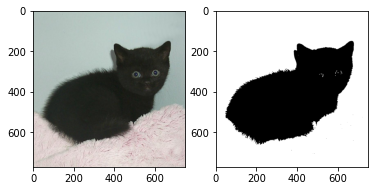

(50, 50, 3)
Original cluster by vq clustering:
 [1 2 2 ... 1 1 1]


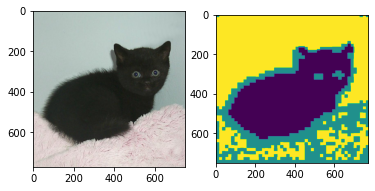

(50, 50, 3)
Original cluster by hierarchy clustering:
 <function cluster at 0x7fcfb3349e18>


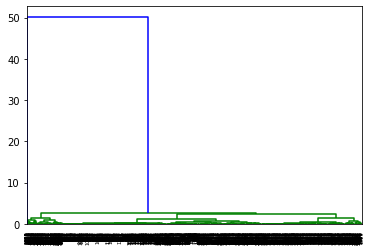

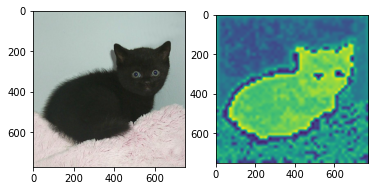

In [0]:
import os 
# !pip3 install scipy==1.1.0 
# !pip3 install pillow
os.chdir("/content/sample_data")
import PIL.Image as image
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from pylab import  *
from PIL import Image
import cv2 
from scipy.cluster.vq import *
import scipy
import scipy.cluster.hierarchy as sch
import matplotlib.pylab as plt
import numpy as np


def load_data(file_path):
    f = open(file_path,'rb') #二进制打开
    data = []
    img = image.open(f) #以列表形式返回图片像素值
    m,n = img.size #活的图片大小
    for i in range(m):
        for j in range(n):  #将每个像素点RGB颜色处理到0-1范围内并存放data
            x,y,z = img.getpixel((i,j))
            data.append([x/256.0,y/256.0,z/256.0])
    f.close()
    return np.mat(data),m,n #以矩阵型式返回data，图片大小




def putpixel(img,n_clusters,signal):
  img_data,row,col = load_data(img)
  if signal==1:
    label = KMeans(n_clusters=n_clusters).fit_predict(img_data)  #聚类中心的个数为3
  else:
    # label = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(img_data)  #层次聚类聚类中心的个数为3

    #1. 层次聚类
    #生成点与点之间的距离矩阵,这里用的欧氏距离:
    disMat = sch.distance.pdist(img_data,'euclidean') 
    #进行层次聚类:
    Z=sch.linkage(disMat,method='average') 
    #将层级聚类结果以树状图表示出来并保存为plot_dendrogram.png
    P=sch.dendrogram(Z)
    plt.savefig('plot_dendrogram.png')
    #根据linkage matrix Z得到聚类结果:
    label= sch.fcluster(Z,t=1,criterion='inconsistent')
    print("Original cluster by hierarchy clustering:\n",cluster)


  label = label.reshape([row,col],)    #聚类获得每个像素所属的类别
  pic_new = image.new("L",(row,col))  #创建一张新的灰度图保存聚类后的结果
  for i in range(row):    #根据所属类别向图片中添加灰度值
      for j in range(col):
          pic_new.putpixel((i,j),int(256/(label[i][j]+1)))
  im = np.array(image.open(img))
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(im)
  plt.subplot(1,2,2)
  plt.imshow(pic_new, cmap = "gray")
  plt.show()

putpixel('2.jpg',2,1)
# 全图做层次聚类 内存爆满
# putpixel('2.jpg',2,0)




'''创建用于归一化割的矩阵，其中 sigma_d 和 sigma_g 是像素距离和像素相似性的权重参数'''
def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
     """ 创建用于归一化割的矩阵，其中 sigma_d 和 sigma_g 是像素距离和像素相似性的权重参数 """
     m,n = im.shape[:2]
     N = m*n
     # 归一化，并创建 RGB 或灰度特征向量
     if len(im.shape)==3:
         for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()

         print(im.shape)
         vim = im.reshape((-1,3))
     else:
         im = im / im.max()
         vim = im.flatten()
     # x,y 坐标用于距离计算
     xx,yy = np.meshgrid(range(n),range(m))
     x,y = xx.flatten(),yy.flatten()
     # 创建边线权重矩阵
     W = np.zeros((N,N),'f')
     for i in range(N):
         for j in range(i,N):
             d = (x[i]-x[j])**2 + (y[i]-y[j])**2
             W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
     return W




'''从相似性矩阵进行谱聚类'''
def cluster(S,k,ndim,signal):
     """ 从相似性矩阵进行谱聚类 """
     # 检查对称性
     if sum(abs(S-S.T)) > 1e-10:
         print('not symmetric')
     # 创建拉普拉斯矩阵
     rowsum = sum(abs(S),axis=0)
     D = np.diag(1 / np.sqrt(rowsum + 1e-6))
     L = np.dot(D,np.dot(S,D))
     # 计算 L 的特征向量
     U,sigma,V = np.linalg.svd(L)
     # 从前 ndim 个特征向量创建特征向量
     # 堆叠特征向量作为矩阵的列
     features = np.array(V[:ndim]).T
     # K-means 聚类
     #将features做归一化处理
     features = whiten(features)
     if signal==1:
        centroids,distortion = kmeans(features,k)
        #使用vq函数根据聚类中心对所有数据进行分类,vq的输出也是两维的,[0]表示的是所有数据的label
        code,distance = vq(features,centroids)
        print("Original cluster by vq clustering:\n",code)
     else:
        #1. 层次聚类
        #生成点与点之间的距离矩阵,这里用的欧氏距离:
        disMat = sch.distance.pdist(features,'euclidean') 
        #进行层次聚类:
        Z=sch.linkage(disMat,method='average') 
        #将层级聚类结果以树状图表示出来并保存为plot_dendrogram.png
        P=sch.dendrogram(Z)
        plt.savefig('plot_dendrogram.png')
        #根据linkage matrix Z得到聚类结果:
        code= sch.fcluster(Z,t=1,criterion='inconsistent')
        print("Original cluster by hierarchy clustering:\n",cluster)

     return code




def paint(img,k,ndim,signal):
  im = array(Image.open(img))
  m,n = im.shape[:2]
  wid = 50

  # 调整图像的尺寸大小为 (wid,wid)

  # rim = np.array(Image.fromarray(im).resize((wid,wid)))
  rim=cv2.resize(im,(wid,wid),interpolation=cv2.INTER_LINEAR)
  # rim = imresize(im,(wid,wid),interp='bilinear')
  rim = array(rim,'f')
  # 创建归一化割矩阵
  A =ncut_graph_matrix(rim,sigma_d=1,sigma_g=1e-2)
  # 聚类
  code =cluster(S=A,k=k,ndim=ndim,signal=signal)
  # 变换到原来的图像大小
  codeim = np.array(Image.fromarray(code.reshape(wid,wid)).resize((m,n)))
  # cv2.resize(src,dsize,dst=None,fx=None,fy=None,interpolation=None)
  # codeim = imresize(code.reshape,(m,n),interp=)
  # codeim = cv2.resize(code,(wid,wid))
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(im)
  plt.subplot(1,2,2)
  plt.imshow(codeim)
  # plt.imshow(codeim, cmap = "gray")
  plt.show()

paint('2.jpg',3,3,1)
# 做完特征分解，可以使用层次聚类
paint('2.jpg',2,3,0)














In [0]:
import scipy
import scipy.cluster.hierarchy as sch
from scipy.cluster.vq import vq,kmeans,whiten
import numpy as np
import matplotlib.pylab as plt


1.linkage(y, method=’single’, metric=’euclidean’) 
共包含3个参数: 
y是距离矩阵,由pdist得到;method是指计算类间距离的方法,比较常用的有3种: 
(1)single:最近邻,把类与类间距离最近的作为类间距 
(2)complete:最远邻,把类与类间距离最远的作为类间距 
(3)average:平均距离,类与类间所有pairs距离的平均

2.fcluster(Z, t, criterion=’inconsistent’, depth=2, R=None, monocrit=None) 
第一个参数Z是linkage得到的矩阵,记录了层次聚类的层次信息; t是一个聚类的阈值

3.kmeans(obs, k_or_guess, iter=20, thresh=1e-05, check_finite=True) 
输入obs是数据矩阵,行代表数据数目,列代表特征维度; k_or_guess表示聚类数目;iter表示循环次数,最终返回损失最小的那一次的聚类中心; 
输出有两个,第一个是聚类中心(codebook),第二个是损失distortion,即聚类后各数据点到其聚类中心的距离的加和.

4.vq(obs, code_book, check_finite=True) 
根据聚类中心将所有数据进行分类.obs为数据,code_book则是kmeans产生的聚类中心. 
输出同样有两个:第一个是各个数据属于哪一类的label,第二个和kmeans的第二个输出是一样的,都是distortion